In [4]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']

In [5]:
client = pymongo.MongoClient('localhost',27017)
db  = client['ximalaya']
gift_rank = db['gift_rank']

In [6]:
data = pd.DataFrame(list(gift_rank.find()))

- 删除MongoDB中的_id列

In [7]:
data.drop(['_id'], axis=1, inplace=True)

- 查看数据类型

In [8]:
data.dtypes

contribution      int64
liveStatus      float64
nickname         object
rank              int64
uid               int64
roomId          float64
type             object
create_time      object
dtype: object

- 查看所有包含NaN的数据

In [9]:
data[data.isnull().T.any().T]

,contribution,liveStatus,nickname,rank,uid,roomId,type,create_time
1613,870,NaN,____小丑,35,161184145,NaN,hour,2020-02-14 02:58:03
9167,160,NaN,珊珊夜阑,22,199140543,NaN,hour,2020-02-20 06:58:02


- 将NaN值修改为指定值，因为包含NaN的列在进行类型转换时会出错

In [10]:
values = {'liveStatus': 0, 'roomId': 0}
data.fillna(value=values, inplace=True)

- 修改liveStatus、roomId数据类型

In [11]:
data = data.astype({'liveStatus': np.int64, 'roomId': np.int64})

In [12]:
data.dtypes

contribution     int64
liveStatus       int64
nickname        object
rank             int64
uid              int64
roomId           int64
type            object
create_time     object
dtype: object

In [13]:
data.head()

,contribution,liveStatus,nickname,rank,uid,roomId,type,create_time
0,5299,9,逗瓣,1,4416963,114,hour,2020-02-12 19:58:00
1,4069,9,萌叽_三月三,2,130564791,930094,hour,2020-02-12 19:58:00
2,3307,9,董咚儿_JLsound,3,84434603,1244753,hour,2020-02-12 19:58:00
3,3173,9,亚辰_燃点娱乐,4,197467038,1587616,hour,2020-02-12 19:58:00
4,2941,9,半岛玫瑰_九星,5,7312748,17214,hour,2020-02-12 19:58:00


- 复制一份数据用于统计分时数据

In [14]:
df_hour = data.copy()

- 将时间字符串转为时间对象

In [15]:
df_hour['create_time'] = pd.to_datetime(df_hour['create_time'])
df_hour.head()

,contribution,liveStatus,nickname,rank,uid,roomId,type,create_time
0,5299,9,逗瓣,1,4416963,114,hour,2020-02-12 19:58:00
1,4069,9,萌叽_三月三,2,130564791,930094,hour,2020-02-12 19:58:00
2,3307,9,董咚儿_JLsound,3,84434603,1244753,hour,2020-02-12 19:58:00
3,3173,9,亚辰_燃点娱乐,4,197467038,1587616,hour,2020-02-12 19:58:00
4,2941,9,半岛玫瑰_九星,5,7312748,17214,hour,2020-02-12 19:58:00


- 只取时分秒部分

In [16]:
df_hour['create_time'] = df_hour['create_time'].dt.time
df_hour.head()

,contribution,liveStatus,nickname,rank,uid,roomId,type,create_time
0,5299,9,逗瓣,1,4416963,114,hour,19:58:00
1,4069,9,萌叽_三月三,2,130564791,930094,hour,19:58:00
2,3307,9,董咚儿_JLsound,3,84434603,1244753,hour,19:58:00
3,3173,9,亚辰_燃点娱乐,4,197467038,1587616,hour,19:58:00
4,2941,9,半岛玫瑰_九星,5,7312748,17214,hour,19:58:00


- 取出所有正在直播的记录

In [17]:
df_live = df_hour[df_hour['liveStatus'] == 9]
df_live.head()

,contribution,liveStatus,nickname,rank,uid,roomId,type,create_time
0,5299,9,逗瓣,1,4416963,114,hour,19:58:00
1,4069,9,萌叽_三月三,2,130564791,930094,hour,19:58:00
2,3307,9,董咚儿_JLsound,3,84434603,1244753,hour,19:58:00
3,3173,9,亚辰_燃点娱乐,4,197467038,1587616,hour,19:58:00
4,2941,9,半岛玫瑰_九星,5,7312748,17214,hour,19:58:00


- 处理时间数据，将小时单独统计

In [18]:
def to_hour(item):
    return item.hour + 1
df_live.loc[:, 'hour'] = df_live['create_time'].apply(to_hour)
df_live = df_live.astype({'hour': np.int32})

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
info_data = df_live['hour'].value_counts()

- 绘制曲线图

In [23]:
sort_data = info_data.sort_index()
sort_data

1     511
2     472
3     430
4     412
5     386
6     385
7     343
8     375
9     470
10    452
11    533
12    470
13    456
14    485
15    513
16    518
17    485
18    433
19    423
20    542
21    508
22    558
23    520
24    776
Name: hour, dtype: int64

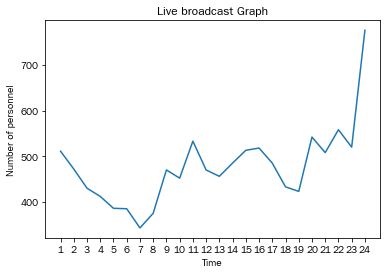

In [21]:
x = list(sort_data.index)
y = list(sort_data.values)
plt.plot(x, y)

# 设置x轴的刻度
plt.xticks(x)
plt.xlabel('Time')
plt.ylabel('Number of personnel')
plt.title('Live broadcast Graph')
plt.show()

由上面的折线图可以看出每天晚上0点直播人数是最多的，其次就是黄金8点

- 统计每个时间段的礼物数

In [24]:
# 按照时间段分组统计里无数
con_data = df_live['contribution'].groupby(df_live['hour']).sum()
con_data

hour
1      3147870
2      1649988
3       825839
4       585842
5       394951
6       351270
7       315796
8       412182
9       423748
10      808709
11     1064388
12     1030346
13     1415808
14     1367648
15     1692000
16     2015344
17     1471033
18     1125828
19     1036943
20     1595519
21     2521951
22     3731900
23     3310312
24    21246620
Name: contribution, dtype: int64

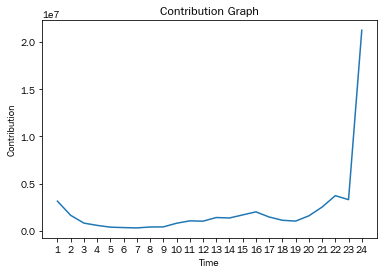

In [25]:
x = list(con_data.index)
y = list(con_data.values)
plt.plot(x, y)

# 设置x轴的刻度
plt.xticks(x)
plt.xlabel('Time')
plt.ylabel('Contribution')
plt.title('Contribution Graph')
plt.show()

由上面的折线图我们可以看到每天22点-1点，礼物刷的是最多的，因为喜马拉雅上每日礼物结算最高的会有奖励，所以主播们这个时候也比较拼，当然各位土豪这个时候
跟主播一起拼，这些大哥们也是挺会疼人的。

接下来我们统计一下每天主播能获得多少礼物，哪些主播比较火，上榜次数多

- 获取每天排行榜第一的主播

In [26]:
df_day = data[(data['type'] == 'day')]
df_day

,contribution,liveStatus,nickname,rank,uid,roomId,type,create_time
201,49505,9,蓝阿_,1,211012094,1733927,day,2020-02-12 23:58:00
203,48030,9,花千骨_九星,2,127140363,991808,day,2020-02-12 23:58:00
205,39055,9,温宁_Qy,3,110225008,461269,day,2020-02-12 23:58:00
207,38892,1,鹿苑_怪兽Monster,4,167258316,1125329,day,2020-02-12 23:58:00
209,38115,5,苏妃,5,157269668,1023237,day,2020-02-12 23:58:00
...,...,...,...,...,...,...,...,...
13642,14826,1,林御儿_九星,46,142093517,935525,day,2020-02-23 23:58:05
13645,14686,9,奶盖_Shiny,47,86127849,21963,day,2020-02-23 23:58:05
13648,14685,9,毒药_金牌段子手,48,196694943,1582890,day,2020-02-23 23:58:05
13651,14508,9,百万小姐姐,49,137683990,894720,day,2020-02-23 23:58:05


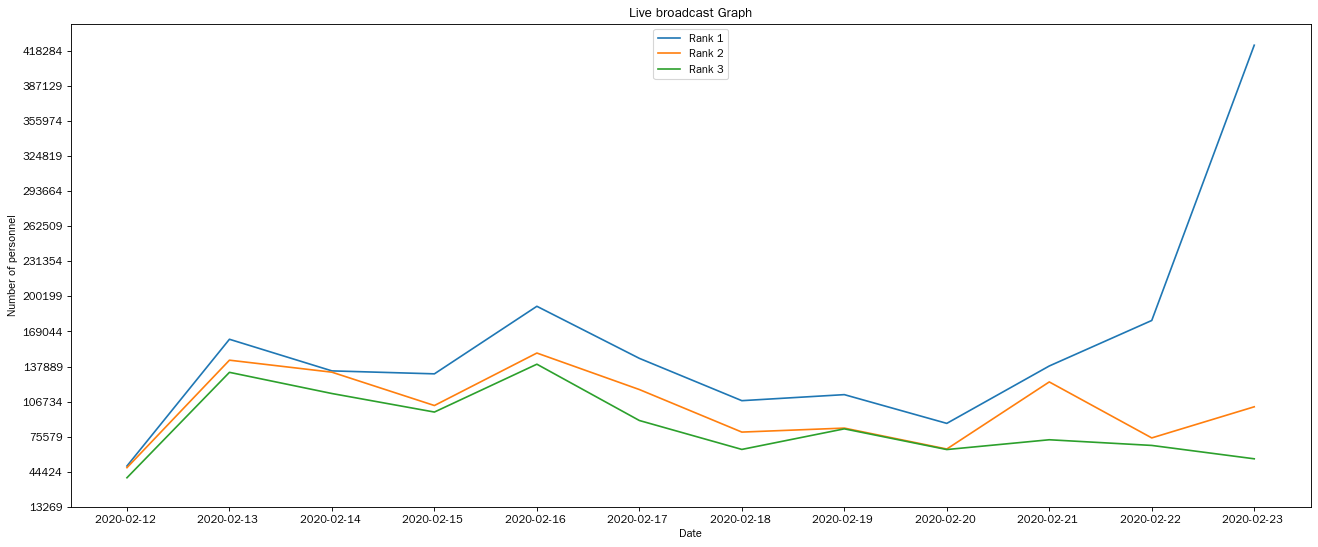

In [27]:
plt.figure(figsize=(20, 8), dpi=80)

# 榜单第一名的数据
df_rank1 = df_day[df_day['rank'] == 1]
plt.plot(df_rank1['create_time'].str[:11], df_rank1['contribution'], label='Rank 1')

# 榜单第一名的数据
df_rank2 = df_day[df_day['rank'] == 2]
plt.plot(df_rank2['create_time'].str[:11], df_rank2['contribution'], label='Rank 2')

# 榜单第三名的数据
df_rank3 = df_day[df_day['rank'] == 3]
plt.plot(df_rank3['create_time'].str[:11], df_rank3['contribution'], label='Rank 3')

plt.xlabel('Date')
plt.ylabel('Number of personnel')
plt.title('Live broadcast Graph')

# 显示图例，并定位在中间
plt.legend(loc='upper center')

step = (max(df_rank1['contribution']) + 1 - min(df_rank1['contribution'])) / len(df_rank1)
plt.yticks(range(min(df_day['contribution']), max(df_day['contribution']) + 1, int(step)))
plt.show()

因为我们抓取的数据量比较小，时间短，不能真实反映直播状况，所以我们选择绘制每天排名前三的主播礼物信息，根据图上我们发现**13、16号的
礼物**数量相对比较高。至于23号那个突破天际的，有可能是大哥喝酒了或者主播又开了一个什么特别场，比如周年场、生日场之类的。这种时候大哥
们也比较嗨，终于有一个特别的日子可以为自己的小甜甜挥霍了。

接下来我们从小时榜里看看哪些主播出现次数比较多

- 热门主播

In [28]:
df_hot = data[data['type'] == 'hour']
df_hot.head()

,contribution,liveStatus,nickname,rank,uid,roomId,type,create_time
0,5299,9,逗瓣,1,4416963,114,hour,2020-02-12 19:58:00
1,4069,9,萌叽_三月三,2,130564791,930094,hour,2020-02-12 19:58:00
2,3307,9,董咚儿_JLsound,3,84434603,1244753,hour,2020-02-12 19:58:00
3,3173,9,亚辰_燃点娱乐,4,197467038,1587616,hour,2020-02-12 19:58:00
4,2941,9,半岛玫瑰_九星,5,7312748,17214,hour,2020-02-12 19:58:00


- 按照主播名统计在小时榜出现的次数

In [29]:
df_hot['nickname'].value_counts()

陈臻臻           99
苏妃            93
阿西_           87
Star_黄泥       78
木子晶_浅音        77
              ..
听枫_合耳盟         1
张筱筠__鸿啸        1
一只过分迷人的小浪辞     1
Ellen_静        1
21点57慕_九星      1
Name: nickname, Length: 2034, dtype: int64

我们把排名前三的主播直播时间绘制出来，看一看他们的直播规律

- 同样的转换时间为小时

In [30]:
def to_hour(item):
    return int(item[11:13]) + 1
df_hot.loc[:, 'hour'] = df_hot['create_time'].apply(to_hour)
df_hot = df_hot.astype({'hour': np.int32})
df_hot.head()

,contribution,liveStatus,nickname,rank,uid,roomId,type,create_time,hour
0,5299,9,逗瓣,1,4416963,114,hour,2020-02-12 19:58:00,20
1,4069,9,萌叽_三月三,2,130564791,930094,hour,2020-02-12 19:58:00,20
2,3307,9,董咚儿_JLsound,3,84434603,1244753,hour,2020-02-12 19:58:00,20
3,3173,9,亚辰_燃点娱乐,4,197467038,1587616,hour,2020-02-12 19:58:00,20
4,2941,9,半岛玫瑰_九星,5,7312748,17214,hour,2020-02-12 19:58:00,20


In [31]:
# 陈臻臻
hot_df1 = df_hot[df_hot['nickname'] == '陈臻臻']

# 直播次数
hot_data1 = hot_df1['hour'].value_counts()
hot_data1 = hot_data1.sort_index()

# 获得礼物数
hot_gift1 = hot_df1['contribution'].groupby(hot_df1['hour']).sum()


# 苏妃
hot_df2 = df_hot[df_hot['nickname'] == '苏妃']
hot_data2 = hot_df2['hour'].value_counts()
hot_data2 = hot_data2.sort_index()
hot_gift2 = hot_df2['contribution'].groupby(hot_df2['hour']).sum()

# 阿西_
hot_df3 = df_hot[df_hot['nickname'] == '阿西_']
hot_data3 = hot_df3['hour'].value_counts()
hot_data3 = hot_data3.sort_index()
hot_gift3 = hot_df3['contribution'].groupby(hot_df3['hour']).sum()

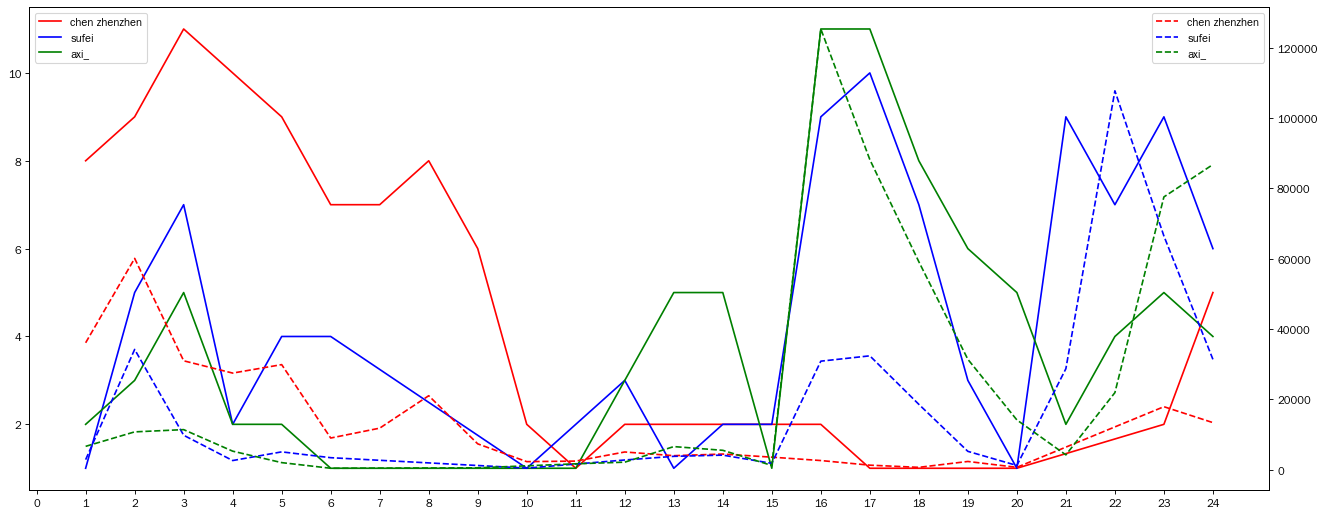

In [32]:
fig = plt.figure(figsize=(20, 8), dpi=80)

ax = fig.add_subplot()

# 绘制直播次数图
ax.plot(hot_data1.index, hot_data1.values, label='chen zhenzhen', color='red')
ax.plot(hot_data2.index, hot_data2.values, label='sufei', color='blue')
ax.plot(hot_data3.index, hot_data3.values, label='axi_', color='green')
ax.legend(loc='upper left')

# 绘制直播收益图
ax1 = ax.twinx()
ax1.plot(hot_gift1.index, hot_gift1.values, '--', label='chen zhenzhen', color='red')
ax1.plot(hot_gift2.index, hot_gift2.values, '--', label='sufei', color='blue')
ax1.plot(hot_gift3.index, hot_gift3.values, '--', label='axi_', color='green')
ax1.legend(loc='upper right')

plt.xticks(range(25))

plt.show()

通过以上数据我们发现陈臻臻的直播时间大概集中在晚上23~8点，小妹妹蜀黍建议你不能老是这样哦，会熬坏身体滴^_^。同时这个小妹妹为我们提
供了一个隐性的数据。按道理小时榜比较多的情况下，日榜应该也会比较高，但是这个小妹却不遵循这样的规律。那么我们得出一个结论：熬夜的人
比较少，主播和观众都一样，因此这个小妹有幸霸榜。

第二名苏妃这个直播时间比较魔性，高峰期出现在3点、17点、21点、23点，这位老妹你要注意身体，每天休息的时间好像就早上那么一会了。

第三名阿西_高峰期出现在3点、17点，相对来说稍微好一点。

从收益来看，收益最高是阿西_，在下午16点，其次是苏妃，在晚上22点，从上面我们也可以看出，苏妃虽然在凌晨和下午直播频次也比较高，但是
收益比较低，说明她的大哥在这个时间段是不出没的，这个时间段收益比不高，建议这位小妹可以减少这两个时段的直播次数。陈臻臻同学的直播收益正如我们上面所分析的，虽然霸榜次数多，但是人少，整体收益也少。

最后我们点一下题，看看这些**主播到底有多赚钱**

因为我只抓取了12天的数据，我们就汇总这12天的数据进行计算，按主播进行分类，把日榜当中的所有收益加起来，喜马拉雅上的喜爱值和现金转换：
基本是一块钱的礼物有3个喜爱值，礼物越大，喜爱值越多，我们按照4个算一块钱。这些收益到主播手里还有比较复杂的计算方式，比如工会收成、
任务完成后分得的比例增大等等，我们就粗暴一点，用最低的方式来计算主播收益，基本就是折半。

In [33]:
income_data = df_day['contribution'].groupby(df_day['nickname']).sum()

In [34]:
income_data = income_data / 8

In [35]:
income_data = income_data.sort_values()

- 赚钱最多和最少的

In [36]:
max(income_data), min(income_data)

(77587.75, 1673.25)

我们把赚钱最多的十位主播绘制出来看看

In [37]:
max_income = income_data[-10:]
max_income

nickname
薇安_千凰       48905.500
小乞丐_SoMo    49536.250
Star_大熊     50382.875
苏妃          55095.000
TL_諾允       56111.625
三叁          58412.625
阿西_         73316.625
NJ语瞳        74589.250
Cc丶_        75295.125
貂蝉宝宝_九星     77587.750
Name: contribution, dtype: float64

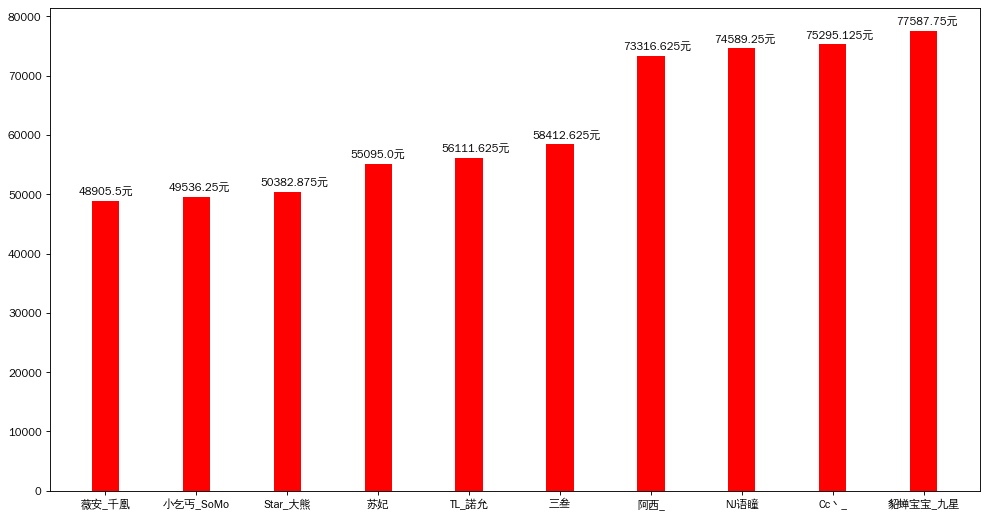

In [38]:
plt.figure(figsize=(15, 8), dpi=80)
plt.bar(range(10), max_income.values, width=0.3, color='red')
plt.xticks(range(10), max_income.index)

for i in range(10):
    plt.text(i - 0.3, max_income.values[i]+1000, str(max_income.values[i]) + '元')
plt.show()

### 总结
仅仅12天，最高收益达到了接近8万，我们还是按最低收益方式计算的，听众消费消费金额逼近20万，当然通过上面的那些分析，我们知道真正赚钱
的主播只有那么几十人而已，虽然很赚钱，你也不要羡慕，不要只看表面的风光，人家在背后还有努力哦^_^

今天我们只分析了主播榜单的一些数据，当然还有其他的信息可以挖掘，我会把爬取的数据上传到GitHub项目上，另外我们还爬取了主播直播间信息，
也是有很多可以分析的点，后面有时间再说吧。数据我们也会上传到GitHub上，有兴趣的同学可以自己分析